#Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import math
import numpy as np
import os
from collections import Counter
import tarfile
import shutil
import tempfile
import urllib.request
import math
import random
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
data_dir='data/'
url = 'http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz'
filename = 'simple-examples.tgz'
filepath = os.path.join(tempfile.gettempdir(), filename)

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Download the dataset
if not os.path.exists(filepath):
    print("Downloading PTB dataset...")
    urllib.request.urlretrieve(url, filepath)
    print("Download complete.")
else:
    print("PTB dataset already downloaded.")

# Extract the dataset
extracted_path = os.path.join(tempfile.gettempdir(), 'simple-examples')
if not os.path.exists(extracted_path):
    print("Extracting PTB dataset...")
    with tarfile.open(filepath, 'r:gz') as tar:
        tar.extractall(path=tempfile.gettempdir())
    print("Extraction complete.")
else:
    print("PTB dataset already extracted.")

# Move the necessary files to the data_dir
for split in ['train', 'valid', 'test']:
    src = os.path.join(extracted_path, 'data', f'ptb.{split}.txt')
    dst = os.path.join(data_dir, f'ptb.{split}.txt')
    if not os.path.exists(dst):
        shutil.copy(src, dst)
        print(f"Copied {split} data to {dst}")
    else:
        print(f"{split} data already exists at {dst}")

Download complete.
Extracting PTB dataset...
Extraction complete.
Copied train data to data/ptb.train.txt
Copied valid data to data/ptb.valid.txt
Copied test data to data/ptb.test.txt


#Data Preprocessing

In [3]:
def preprocess_data(file_path):
    tokens = []
    with open(file_path, 'r') as file:
        for line in file.readlines():
            line_tokens = line.strip().split()
            line_tokens.append('<eos>')
            tokens.extend(line_tokens)
    print(f"Total tokens: {len(tokens)}")
    print(tokens[:10])
    return tokens

# Paths to Penn Tree Bank dataset files
train_file_path = 'data/ptb.train.txt'
valid_file_path = 'data/ptb.valid.txt'
test_file_path = 'data/ptb.test.txt'

train_tokens = preprocess_data(train_file_path)
valid_tokens = preprocess_data(valid_file_path)
test_tokens = preprocess_data(test_file_path)

Total tokens: 929589
['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro-quebec']
Total tokens: 73760
['consumers', 'may', 'want', 'to', 'move', 'their', 'telephones', 'a', 'little', 'closer']
Total tokens: 82430
['no', 'it', 'was', "n't", 'black', 'monday', '<eos>', 'but', 'while', 'the']


In [4]:
def build_vocab(token_list):
    counter = Counter(token_list)
    vocab = sorted(counter, key=counter.get, reverse=True)

    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for word, idx in word2idx.items()}
    vocab_size = len(word2idx)

    # Check vocab size
    print(f"Vocabulary built. Total words: {vocab_size}")
    return word2idx, idx2word, vocab_size


def encode_tokens(tokens, word2idx):
    encoded_tokens = [word2idx.get(token, word2idx["<unk>"]) for token in tokens]
    return encoded_tokens

word2idx, idx2word, vocab_size = build_vocab(train_tokens)

train_data = encode_tokens(train_tokens, word2idx)
valid_data = encode_tokens(valid_tokens, word2idx)
test_data = encode_tokens(test_tokens, word2idx)

print(train_data[:10])
print(valid_data[:10])
print(test_data[:10])

Vocabulary built. Total words: 10000
[9970, 9971, 9972, 9973, 9974, 9975, 9976, 9977, 9978, 9979]
[1134, 93, 358, 5, 329, 51, 9586, 6, 326, 2484]
[102, 14, 24, 32, 753, 381, 2, 29, 120, 0]


In [5]:
print("Max index in train_data:", max(train_data))
print("Max index in valid_data:", max(valid_data))
print("Max index in test_data:", max(test_data))
print("Vocab size:", vocab_size)

Max index in train_data: 9999
Max index in valid_data: 9999
Max index in test_data: 9974
Vocab size: 10000


In [6]:
def batchify(data, batch_size):
    nbatch = len(data) // batch_size
    data = data[:nbatch * batch_size]
    data = torch.tensor(data, dtype=torch.long).to(device)
    data = data.view(batch_size, -1)
    return data

batch_size = 20
train_data = batchify(train_data, batch_size)
valid_data = batchify(valid_data, batch_size)
test_data = batchify(test_data, batch_size)

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

torch.Size([20, 46479])
torch.Size([20, 3688])
torch.Size([20, 4121])


#Model Architecture

In [7]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size=200, hidden_size=200, num_layers=2, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.encoder = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(dropout)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, dropout=dropout)
        self.decoder = nn.Linear(hidden_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()

    def forward(self, input, hidden):
        assert (input >= 0).all() and (input < vocab_size).all(), "Input indices out of bounds!"
        emb = self.dropout(self.encoder(input))
        output, hidden = self.lstm(emb, hidden)
        output = self.dropout(output)
        decoded = self.decoder(output.view(output.size(0) * output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters())
        return (weight.new_zeros(self.num_layers, batch_size, self.hidden_size),
                weight.new_zeros(self.num_layers, batch_size, self.hidden_size))



class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=2, dropout=0.0):
        super(GRUModel, self).__init__()
        self.encoder = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(dropout)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(embed_size, hidden_size, num_layers, dropout=dropout)
        self.decoder = nn.Linear(hidden_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()

    def forward(self, input, hidden):
        assert (input >= 0).all() and (input < vocab_size).all(), "Input indices out of bounds!"
        emb = self.dropout(self.encoder(input))
        output, hidden = self.gru(emb, hidden)
        output = self.dropout(output)
        decoded = self.decoder(output.view(output.size(0) * output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters())
        return weight.new_zeros(self.num_layers, batch_size, self.hidden_size)

#Training and Evaluation Loops

In [8]:
seq_len = 20  # Set sequence length to 32
batch_size = 20

In [9]:
def repackage_hidden(h):
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def get_batch(source, i, seq_len, batch_size):
    data = [source[j, i * seq_len:(i + 1) * seq_len] for j in range(batch_size)]
    data = torch.stack(data, dim=1)  # Shape: [seq_len, batch_size]
    target = [source[j, i * seq_len + 1:(i + 1) * seq_len + 1] for j in range(batch_size)]
    target = torch.stack(target, dim=1)  # Shape: [seq_len, batch_size]
    return data, target

In [10]:
def train_epoch(model, train_dataset, optimizer, loss_fn, batch_size, seq_len, device):
    print("entered training loop")
    model.train()
    total_loss = 0
    hidden = model.init_hidden(batch_size)  # Initialize hidden state

    # Calculate the number of batches
    num_batches = train_dataset.size(1) // seq_len
    print(f"Number of batches: {num_batches}")

    for i in tqdm(range(num_batches), total=num_batches, desc="Training"):
        inputs, targets = get_batch(train_dataset, i, seq_len, batch_size=batch_size)
        inputs, targets = inputs.to(device), targets.to(device)
        hidden = repackage_hidden(hidden)
        optimizer.zero_grad()

        # Forward pass
        outputs, hidden = model(inputs, hidden)
        assert outputs.size(2) == vocab_size, "Output dimensions do not match vocab size"

        # Reshape outputs to (batch_size * seq_len, vocab_size) for loss calculation
        loss = loss_fn(outputs.view(-1, vocab_size), targets.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # Gradient clipping
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    perplexity = calculate_perplexity(avg_loss)
    return avg_loss, perplexity


def evaluate(model, data, loss_fn, batch_size, seq_len, device):
    model.eval()
    total_loss = 0
    hidden = model.init_hidden(batch_size)  # Initialize hidden state

    # Calculate the number of batches
    num_batches = data.size(1) // seq_len

    with torch.no_grad():
        for i in tqdm(range(num_batches), total=num_batches, desc="Evaluating"):
            inputs, targets = get_batch(data, i, seq_len, batch_size=batch_size)
            inputs, targets = inputs.to(device), targets.to(device)
            hidden = repackage_hidden(hidden)

            # Forward pass
            outputs, hidden = model(inputs, hidden)  # Shape: (batch_size, seq_len, vocab_size)
            assert outputs.size(2) == vocab_size, "Output dimensions do not match vocab size"

            # Reshape outputs to (batch_size * seq_len, vocab_size) for loss calculation
            loss = loss_fn(outputs.view(-1, vocab_size), targets.view(-1))
            total_loss += loss.item()

    avg_loss = total_loss / num_batches
    perplexity = calculate_perplexity(avg_loss)
    return avg_loss, perplexity

In [11]:
def calculate_perplexity(loss):
    """
    Calculates perplexity from loss.
    """
    return math.exp(loss)

def plot_perplexity(train_ppls, valid_ppls, title, save_path):
    """
    Plots training and validation perplexity over epochs.
    """
    epochs = range(1, len(train_ppls) + 1)
    plt.figure(figsize=(10,6))
    plt.plot(epochs, train_ppls, 'b-', label='Training Perplexity')
    plt.plot(epochs, valid_ppls, 'r-', label='Test Perplexity')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

In [13]:
def run_experiments():
    """
    Runs the four experimental settings and summarizes the results.
    """
    # Define experimental settings
    experiments = [
        {
            'model_type': 'lstm',
            'dropout': 0.0,
            'lr': 1.6,    # Initial learning rate for SGD
            'epochs': 13,
            'save_path': 'checkpoints/lstm_no_dropout',
            'plot_path': 'plots/lstm_no_dropout_perplexity.png'
        },
        {
            'model_type': 'lstm',
            'dropout': 0.5,
            'lr': 3.4,    # Initial learning rate for SGD
            'epochs': 20,
            'save_path': 'checkpoints/lstm_with_dropout',
            'plot_path': 'plots/lstm_with_dropout_perplexity.png'
        },
        {
            'model_type': 'gru',
            'dropout': 0.0,
            'lr': 1.5,    # Initial learning rate for SGD
            'epochs': 13,
            'save_path': 'checkpoints/gru_no_dropout',
            'plot_path': 'plots/gru_no_dropout_perplexity.png'
        },
        {
            'model_type': 'gru',
            'dropout': 0.3,
            'lr': 1.8,    # Initial learning rate for SGD
            'epochs': 20,
            'save_path': 'checkpoints/gru_with_dropout',
            'plot_path': 'plots/gru_with_dropout_perplexity.png'
        }
    ]

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'\nUsing device: {device}\n')

    # Initialize a list to store results
    results = []

    os.makedirs('checkpoints', exist_ok=True)
    os.makedirs('plots', exist_ok=True)

    for exp in experiments:

        os.makedirs(os.path.dirname(exp['save_path']), exist_ok=True)
        os.makedirs(os.path.dirname(exp['plot_path']), exist_ok=True)

        print(f"\n--- Starting Experiment: {exp['model_type'].upper()} with Dropout={exp['dropout']} ---")

        # Initialize model based on the experiment
        if exp['model_type'] == 'lstm':
            model = LSTMModel(vocab_size, embed_size=200, hidden_size=200, num_layers=2, dropout=exp['dropout']).to(device)
        elif exp['model_type'] == 'gru':
            model = GRUModel(vocab_size, embed_size=200, hidden_size=200, num_layers=2, dropout=exp['dropout']).to(device)
        else:
            raise ValueError("Model type must be 'lstm' or 'gru'")

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=exp['lr'])  # Using SGD optimizer

        # Define a lambda function to adjust the learning rate
        if exp['dropout'] == 0.0:
            lambda_lr = lambda epoch: exp['lr'] if epoch < 7 else exp['lr'] * (0.5 ** (epoch - 6))
        else:
            lambda_lr = lambda epoch: exp['lr'] if epoch < 8 else exp['lr'] * (0.75 ** (epoch - 7))
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_lr)

        # Lists to store perplexities per epoch
        train_ppls, valid_ppls, test_ppls = [], [], []
        best_valid_ppl = float('inf')

        # Training and validation loop
        for epoch in range(exp['epochs']):
            print(f'\nEpoch {epoch + 1}/{exp["epochs"]}')

            # Train the model for one epoch
            train_loss, train_ppl = train_epoch(
                model=model,
                train_dataset=train_data,
                optimizer=optimizer,
                loss_fn=criterion,
                batch_size=batch_size,
                seq_len=seq_len,
                device=device
            )
            train_ppls.append(train_ppl)
            print(f'Train Perplexity: {train_ppl:.2f}')

            # Evaluate on validation set
            valid_loss, valid_ppl = evaluate(
                model=model,
                data=valid_data,
                loss_fn=criterion,
                batch_size=batch_size,
                seq_len=seq_len,
                device=device
            )
            valid_ppls.append(valid_ppl)
            print(f'Validation Perplexity: {valid_ppl:.2f}')

            # Test the model on the test set
            test_loss, test_ppl = evaluate(
                model=model,
                data=test_data,
                loss_fn=criterion,
                batch_size=batch_size,
                seq_len=seq_len,
                device=device
            )
            test_ppls.append(test_ppl)
            print(f'Test Perplexity: {test_ppl:.2f}')

            # Save the model if validation perplexity improves
            if valid_ppl < best_valid_ppl:
                best_valid_ppl = valid_ppl
                torch.save(model.state_dict(), exp['save_path'])
                print(f'Best model saved to {exp["save_path"]}')

            # Adjust learning rate using the scheduler
            if scheduler:
                scheduler.step()

        # Plot perplexities for this experiment
        plot_title = f"{exp['model_type'].upper()} with Dropout={exp['dropout']}"
        plot_path = exp['plot_path']
        plot_perplexity(train_ppls, test_ppls, plot_title, plot_path)

        # Store the results
        results.append({
            'Model': exp['model_type'].upper(),
            'Dropout': exp['dropout'],
            'Train Perplexity': min(train_ppls),
            'Validation Perplexity': min(valid_ppls),
            'Test Perplexity': min(test_ppls)
        })

    # Display Results Summary
    print("\n=== Results Summary ===")
    print("| Model | Dropout Probability | Train Perplexity | Validation Perplexity | Test Perplexity |")
    print("|-------|---------------------|------------------|-----------------------|-----------------|")
    for res in results:
        print(f"| {res['Model']} | {res['Dropout']} | {res['Train Perplexity']:.2f} | {res['Validation Perplexity']:.2f} | {res['Test Perplexity']:.2f} |")

#Running Experiments


Using device: cuda


--- Starting Experiment: LSTM with Dropout=0.0 ---

Epoch 1/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:10<00:00, 220.50it/s]


Train Perplexity: 521.11


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 721.59it/s]


Validation Perplexity: 331.66


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 723.42it/s]


Test Perplexity: 322.80
Best model saved to checkpoints/lstm_no_dropout

Epoch 2/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 251.83it/s]


Train Perplexity: 245.19


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 708.71it/s]


Validation Perplexity: 219.53


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 712.64it/s]


Test Perplexity: 214.12
Best model saved to checkpoints/lstm_no_dropout

Epoch 3/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 252.10it/s]


Train Perplexity: 175.95


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 726.39it/s]


Validation Perplexity: 184.11


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 721.68it/s]


Test Perplexity: 180.01
Best model saved to checkpoints/lstm_no_dropout

Epoch 4/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 252.18it/s]


Train Perplexity: 142.67


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 703.96it/s]


Validation Perplexity: 161.37


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 706.32it/s]


Test Perplexity: 158.30
Best model saved to checkpoints/lstm_no_dropout

Epoch 5/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 254.92it/s]


Train Perplexity: 121.89


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 727.25it/s]


Validation Perplexity: 148.26


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 718.17it/s]


Test Perplexity: 145.84
Best model saved to checkpoints/lstm_no_dropout

Epoch 6/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 252.12it/s]


Train Perplexity: 107.21


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 725.50it/s]


Validation Perplexity: 141.52


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 718.88it/s]


Test Perplexity: 139.28
Best model saved to checkpoints/lstm_no_dropout

Epoch 7/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 251.77it/s]


Train Perplexity: 96.18


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 722.83it/s]


Validation Perplexity: 137.19


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 719.53it/s]


Test Perplexity: 134.67
Best model saved to checkpoints/lstm_no_dropout

Epoch 8/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 253.44it/s]


Train Perplexity: 82.86


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 719.73it/s]


Validation Perplexity: 129.77


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 722.37it/s]


Test Perplexity: 126.90
Best model saved to checkpoints/lstm_no_dropout

Epoch 9/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 252.42it/s]


Train Perplexity: 75.84


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 720.81it/s]


Validation Perplexity: 126.29


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 694.47it/s]


Test Perplexity: 123.30
Best model saved to checkpoints/lstm_no_dropout

Epoch 10/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 250.94it/s]


Train Perplexity: 72.41


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 720.53it/s]


Validation Perplexity: 124.36


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 722.40it/s]


Test Perplexity: 121.38
Best model saved to checkpoints/lstm_no_dropout

Epoch 11/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 252.04it/s]


Train Perplexity: 70.71


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 723.12it/s]


Validation Perplexity: 123.21


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 721.13it/s]


Test Perplexity: 120.15
Best model saved to checkpoints/lstm_no_dropout

Epoch 12/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 253.66it/s]


Train Perplexity: 69.85


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 712.19it/s]


Validation Perplexity: 122.46


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 717.12it/s]


Test Perplexity: 119.26
Best model saved to checkpoints/lstm_no_dropout

Epoch 13/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 251.60it/s]


Train Perplexity: 69.39


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 712.20it/s]


Validation Perplexity: 122.04


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 716.03it/s]


Test Perplexity: 118.74
Best model saved to checkpoints/lstm_no_dropout


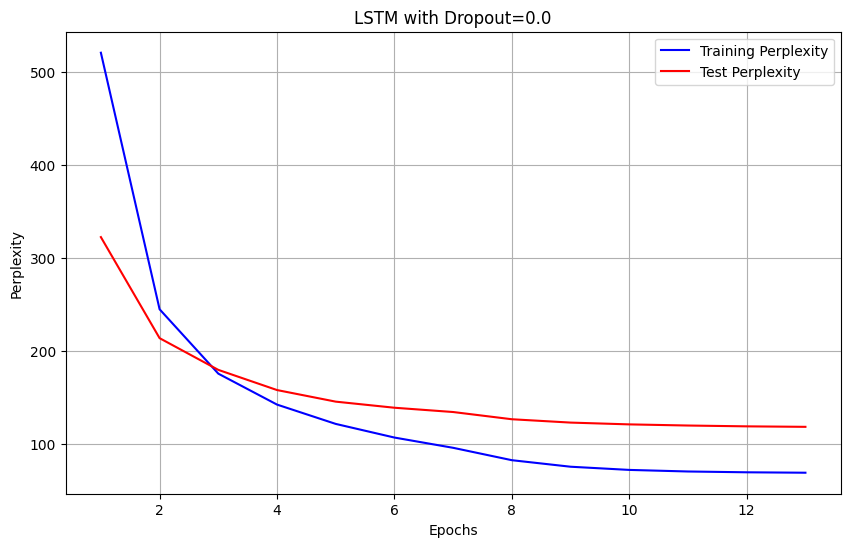


--- Starting Experiment: LSTM with Dropout=0.5 ---

Epoch 1/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 240.00it/s]


Train Perplexity: 394.37


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 713.85it/s]


Validation Perplexity: 237.22


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 713.41it/s]


Test Perplexity: 233.01
Best model saved to checkpoints/lstm_with_dropout

Epoch 2/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 243.00it/s]


Train Perplexity: 224.78


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 712.23it/s]


Validation Perplexity: 183.80


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 707.58it/s]


Test Perplexity: 179.93
Best model saved to checkpoints/lstm_with_dropout

Epoch 3/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 242.19it/s]


Train Perplexity: 188.47


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 720.42it/s]


Validation Perplexity: 162.82


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 715.21it/s]


Test Perplexity: 158.63
Best model saved to checkpoints/lstm_with_dropout

Epoch 4/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 240.87it/s]


Train Perplexity: 170.45


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 712.12it/s]


Validation Perplexity: 152.71


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 723.67it/s]


Test Perplexity: 149.13
Best model saved to checkpoints/lstm_with_dropout

Epoch 5/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 242.92it/s]


Train Perplexity: 159.40


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 722.38it/s]


Validation Perplexity: 142.61


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 732.55it/s]


Test Perplexity: 139.65
Best model saved to checkpoints/lstm_with_dropout

Epoch 6/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 242.76it/s]


Train Perplexity: 152.17


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 712.38it/s]


Validation Perplexity: 137.93


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 714.56it/s]


Test Perplexity: 134.53
Best model saved to checkpoints/lstm_with_dropout

Epoch 7/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 244.18it/s]


Train Perplexity: 146.76


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 718.15it/s]


Validation Perplexity: 134.45


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 720.16it/s]


Test Perplexity: 131.42
Best model saved to checkpoints/lstm_with_dropout

Epoch 8/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 242.72it/s]


Train Perplexity: 142.54


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 723.93it/s]


Validation Perplexity: 131.07


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 724.12it/s]


Test Perplexity: 128.30
Best model saved to checkpoints/lstm_with_dropout

Epoch 9/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 243.83it/s]


Train Perplexity: 134.16


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 707.30it/s]


Validation Perplexity: 125.05


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 717.06it/s]


Test Perplexity: 121.96
Best model saved to checkpoints/lstm_with_dropout

Epoch 10/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 242.48it/s]


Train Perplexity: 127.01


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 714.87it/s]


Validation Perplexity: 120.50


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 722.36it/s]


Test Perplexity: 117.40
Best model saved to checkpoints/lstm_with_dropout

Epoch 11/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 242.93it/s]


Train Perplexity: 121.15


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 718.00it/s]


Validation Perplexity: 117.41


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 717.67it/s]


Test Perplexity: 114.07
Best model saved to checkpoints/lstm_with_dropout

Epoch 12/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 243.43it/s]


Train Perplexity: 117.06


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 722.22it/s]


Validation Perplexity: 114.97


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 714.91it/s]


Test Perplexity: 111.30
Best model saved to checkpoints/lstm_with_dropout

Epoch 13/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 242.39it/s]


Train Perplexity: 113.75


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 715.17it/s]


Validation Perplexity: 113.28


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 713.69it/s]


Test Perplexity: 109.94
Best model saved to checkpoints/lstm_with_dropout

Epoch 14/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 243.10it/s]


Train Perplexity: 111.44


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 720.67it/s]


Validation Perplexity: 112.28


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 719.68it/s]


Test Perplexity: 108.70
Best model saved to checkpoints/lstm_with_dropout

Epoch 15/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 243.39it/s]


Train Perplexity: 109.54


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 714.38it/s]


Validation Perplexity: 110.88


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 710.83it/s]


Test Perplexity: 107.42
Best model saved to checkpoints/lstm_with_dropout

Epoch 16/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 243.57it/s]


Train Perplexity: 108.25


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 708.54it/s]


Validation Perplexity: 110.38


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 719.77it/s]


Test Perplexity: 106.85
Best model saved to checkpoints/lstm_with_dropout

Epoch 17/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 244.28it/s]


Train Perplexity: 107.21


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 710.75it/s]


Validation Perplexity: 109.96


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 723.37it/s]


Test Perplexity: 106.28
Best model saved to checkpoints/lstm_with_dropout

Epoch 18/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 243.36it/s]


Train Perplexity: 106.40


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 712.31it/s]


Validation Perplexity: 109.50


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 721.75it/s]


Test Perplexity: 105.77
Best model saved to checkpoints/lstm_with_dropout

Epoch 19/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 243.98it/s]


Train Perplexity: 105.87


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 719.77it/s]


Validation Perplexity: 109.27


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 716.30it/s]


Test Perplexity: 105.49
Best model saved to checkpoints/lstm_with_dropout

Epoch 20/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 241.91it/s]


Train Perplexity: 105.38


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 716.18it/s]


Validation Perplexity: 109.08


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 709.42it/s]


Test Perplexity: 105.22
Best model saved to checkpoints/lstm_with_dropout


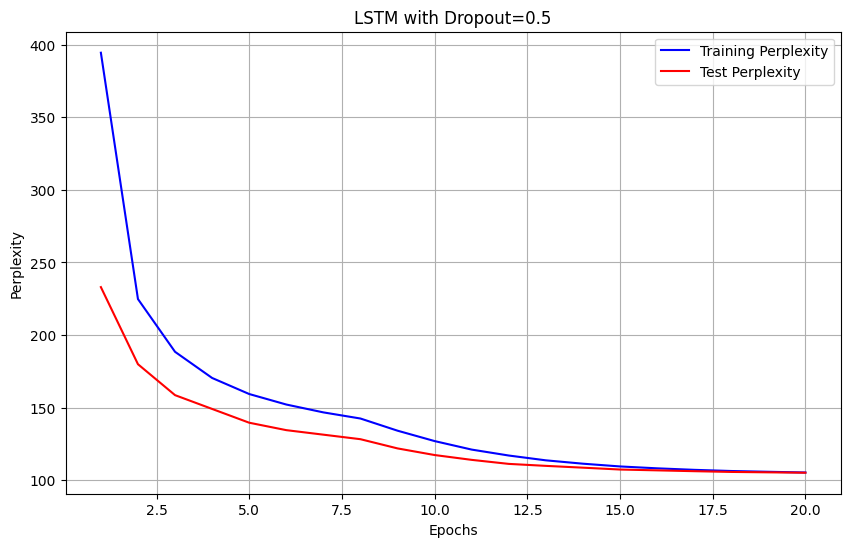


--- Starting Experiment: GRU with Dropout=0.0 ---

Epoch 1/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:08<00:00, 262.83it/s]


Train Perplexity: 384.39


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 726.38it/s]


Validation Perplexity: 243.05


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 725.92it/s]


Test Perplexity: 239.44
Best model saved to checkpoints/gru_no_dropout

Epoch 2/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:08<00:00, 261.47it/s]


Train Perplexity: 181.64


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 710.48it/s]


Validation Perplexity: 177.35


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 711.26it/s]


Test Perplexity: 173.73
Best model saved to checkpoints/gru_no_dropout

Epoch 3/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:08<00:00, 264.50it/s]


Train Perplexity: 134.54


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 717.81it/s]


Validation Perplexity: 154.05


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 725.44it/s]


Test Perplexity: 151.08
Best model saved to checkpoints/gru_no_dropout

Epoch 4/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:08<00:00, 265.21it/s]


Train Perplexity: 109.84


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 711.32it/s]


Validation Perplexity: 142.84


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 724.07it/s]


Test Perplexity: 140.09
Best model saved to checkpoints/gru_no_dropout

Epoch 5/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:08<00:00, 261.21it/s]


Train Perplexity: 93.77


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 723.73it/s]


Validation Perplexity: 138.15


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 725.11it/s]


Test Perplexity: 135.21
Best model saved to checkpoints/gru_no_dropout

Epoch 6/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:08<00:00, 263.38it/s]


Train Perplexity: 82.23


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 720.84it/s]


Validation Perplexity: 135.83


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 722.98it/s]


Test Perplexity: 133.02
Best model saved to checkpoints/gru_no_dropout

Epoch 7/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:08<00:00, 265.57it/s]


Train Perplexity: 73.44


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 725.41it/s]


Validation Perplexity: 136.48


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 720.77it/s]


Test Perplexity: 133.78

Epoch 8/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:08<00:00, 262.23it/s]


Train Perplexity: 61.82


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 698.11it/s]


Validation Perplexity: 129.55


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 726.01it/s]


Test Perplexity: 126.48
Best model saved to checkpoints/gru_no_dropout

Epoch 9/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:08<00:00, 264.45it/s]


Train Perplexity: 56.22


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 726.38it/s]


Validation Perplexity: 125.61


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 731.61it/s]


Test Perplexity: 122.35
Best model saved to checkpoints/gru_no_dropout

Epoch 10/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:08<00:00, 264.09it/s]


Train Perplexity: 53.54


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 731.27it/s]


Validation Perplexity: 123.37


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 731.91it/s]


Test Perplexity: 119.89
Best model saved to checkpoints/gru_no_dropout

Epoch 11/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:08<00:00, 263.30it/s]


Train Perplexity: 52.21


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 727.01it/s]


Validation Perplexity: 122.21


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 716.19it/s]


Test Perplexity: 118.41
Best model saved to checkpoints/gru_no_dropout

Epoch 12/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:08<00:00, 261.27it/s]


Train Perplexity: 51.50


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 717.22it/s]


Validation Perplexity: 121.73


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 722.39it/s]


Test Perplexity: 117.69
Best model saved to checkpoints/gru_no_dropout

Epoch 13/13
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:08<00:00, 262.89it/s]


Train Perplexity: 51.11


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 714.89it/s]


Validation Perplexity: 121.48


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 728.51it/s]


Test Perplexity: 117.32
Best model saved to checkpoints/gru_no_dropout


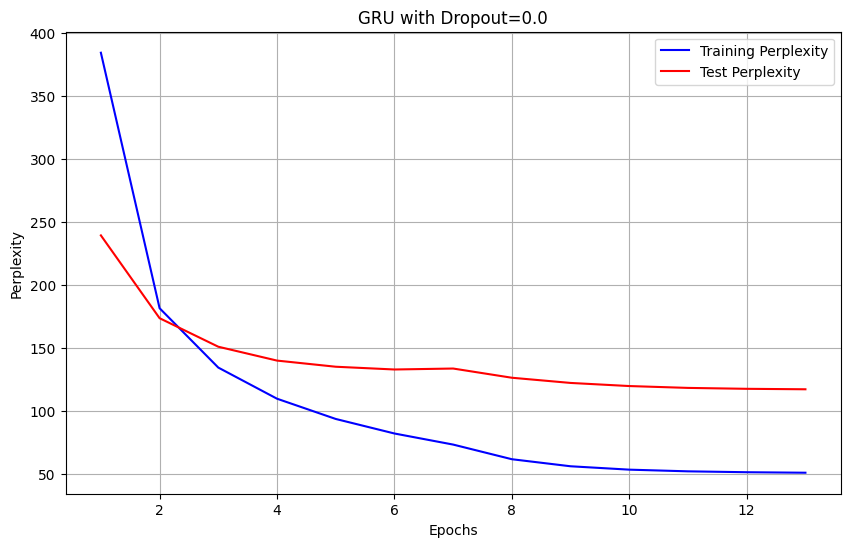


--- Starting Experiment: GRU with Dropout=0.3 ---

Epoch 1/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 254.56it/s]


Train Perplexity: 387.25


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 722.36it/s]


Validation Perplexity: 231.56


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 695.29it/s]


Test Perplexity: 227.78
Best model saved to checkpoints/gru_with_dropout

Epoch 2/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 253.39it/s]


Train Perplexity: 206.39


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 718.43it/s]


Validation Perplexity: 176.56


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 729.75it/s]


Test Perplexity: 173.99
Best model saved to checkpoints/gru_with_dropout

Epoch 3/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 253.90it/s]


Train Perplexity: 164.97


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 720.34it/s]


Validation Perplexity: 155.63


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 729.34it/s]


Test Perplexity: 153.05
Best model saved to checkpoints/gru_with_dropout

Epoch 4/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 252.33it/s]


Train Perplexity: 143.10


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 718.02it/s]


Validation Perplexity: 141.88


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 731.22it/s]


Test Perplexity: 139.09
Best model saved to checkpoints/gru_with_dropout

Epoch 5/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 254.89it/s]


Train Perplexity: 129.05


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 733.52it/s]


Validation Perplexity: 134.98


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 708.55it/s]


Test Perplexity: 133.04
Best model saved to checkpoints/gru_with_dropout

Epoch 6/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 254.32it/s]


Train Perplexity: 119.20


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 729.12it/s]


Validation Perplexity: 129.78


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 724.64it/s]


Test Perplexity: 128.00
Best model saved to checkpoints/gru_with_dropout

Epoch 7/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 256.52it/s]


Train Perplexity: 111.65


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 694.32it/s]


Validation Perplexity: 126.29


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 708.87it/s]


Test Perplexity: 123.84
Best model saved to checkpoints/gru_with_dropout

Epoch 8/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 254.67it/s]


Train Perplexity: 105.85


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 718.07it/s]


Validation Perplexity: 124.73


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 721.45it/s]


Test Perplexity: 122.46
Best model saved to checkpoints/gru_with_dropout

Epoch 9/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 255.75it/s]


Train Perplexity: 97.03


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 728.62it/s]


Validation Perplexity: 118.34


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 724.02it/s]


Test Perplexity: 115.72
Best model saved to checkpoints/gru_with_dropout

Epoch 10/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 256.85it/s]


Train Perplexity: 90.15


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 714.83it/s]


Validation Perplexity: 114.58


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 727.77it/s]


Test Perplexity: 111.84
Best model saved to checkpoints/gru_with_dropout

Epoch 11/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 254.17it/s]


Train Perplexity: 85.25


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 733.16it/s]


Validation Perplexity: 111.75


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 718.18it/s]


Test Perplexity: 108.70
Best model saved to checkpoints/gru_with_dropout

Epoch 12/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 255.71it/s]


Train Perplexity: 81.74


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 724.87it/s]


Validation Perplexity: 109.55


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 734.87it/s]


Test Perplexity: 106.20
Best model saved to checkpoints/gru_with_dropout

Epoch 13/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 254.38it/s]


Train Perplexity: 79.13


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 718.73it/s]


Validation Perplexity: 108.15


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 724.63it/s]


Test Perplexity: 105.01
Best model saved to checkpoints/gru_with_dropout

Epoch 14/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 255.62it/s]


Train Perplexity: 77.33


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 709.39it/s]


Validation Perplexity: 107.01


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 705.80it/s]


Test Perplexity: 103.72
Best model saved to checkpoints/gru_with_dropout

Epoch 15/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 253.55it/s]


Train Perplexity: 75.96


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 732.33it/s]


Validation Perplexity: 106.08


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 728.71it/s]


Test Perplexity: 102.61
Best model saved to checkpoints/gru_with_dropout

Epoch 16/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 256.25it/s]


Train Perplexity: 74.92


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 721.64it/s]


Validation Perplexity: 105.33


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 720.34it/s]


Test Perplexity: 101.92
Best model saved to checkpoints/gru_with_dropout

Epoch 17/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 256.06it/s]


Train Perplexity: 74.20


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 735.26it/s]


Validation Perplexity: 104.97


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 720.83it/s]


Test Perplexity: 101.43
Best model saved to checkpoints/gru_with_dropout

Epoch 18/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 254.65it/s]


Train Perplexity: 73.65


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 728.24it/s]


Validation Perplexity: 104.73


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 717.57it/s]


Test Perplexity: 101.10
Best model saved to checkpoints/gru_with_dropout

Epoch 19/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 253.18it/s]


Train Perplexity: 73.22


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 727.11it/s]


Validation Perplexity: 104.46


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 733.98it/s]


Test Perplexity: 100.82
Best model saved to checkpoints/gru_with_dropout

Epoch 20/20
entered training loop
Number of batches: 2323


Training: 100%|██████████| 2323/2323 [00:09<00:00, 253.76it/s]


Train Perplexity: 72.83


Evaluating: 100%|██████████| 184/184 [00:00<00:00, 715.52it/s]


Validation Perplexity: 104.29


Evaluating: 100%|██████████| 206/206 [00:00<00:00, 724.03it/s]


Test Perplexity: 100.62
Best model saved to checkpoints/gru_with_dropout


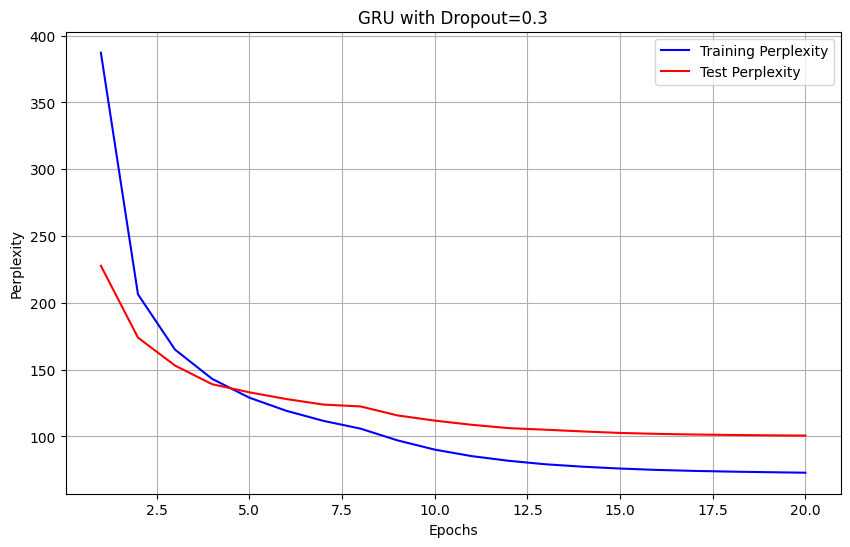


=== Results Summary ===
| Model | Dropout Probability | Train Perplexity | Validation Perplexity | Test Perplexity |
|-------|---------------------|------------------|-----------------------|-----------------|
| LSTM | 0.0 | 69.39 | 122.04 | 118.74 |
| LSTM | 0.5 | 105.38 | 109.08 | 105.22 |
| GRU | 0.0 | 51.11 | 121.48 | 117.32 |
| GRU | 0.3 | 72.83 | 104.29 | 100.62 |


In [14]:
if __name__ == "__main__":
    run_experiments()